In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import networkx as nx
import ast

from nanonets import Simulation
from nanonets.utils import fft, harmonic_strength, total_harmonic_distortion, BLUE_COLOR, get_net_currents, cross_correlation, min_max_scale
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy import signal
from scipy.optimize import curve_fit

plt.style.use(["science","bright","grid"])
PATH = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/amp_freq/"
# PATH = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/amp_freq/"

/home/jonasmensing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
AMPLITUDE_LIST  = [0.02,0.03,0.04,0.05,0.06,0.07,0.08]
FREQ_LIST_MHZ   = [0.005,0.01,0.03,0.06,0.12,0.25,0.5,1.,2.,5.,6.,8.,
                   10.,12.,15.,18.,23.,28.,36.,44.,55.,68.,86.,105.,133.,266.,610.,1200.,2400.]
N_PERIODS       = 100
N_SKIP          = 80
SAMPLE_P_PERIOD = 40
N_ELECTRODES    = 8
N_NP            = 9

topo = {"Nx": N_NP,"Ny": N_NP, "e_pos": [[(N_NP-1)//2, 0],[0, 0],[N_NP-1, 0],
               [0, (N_NP-1)//2],[N_NP-1, (N_NP-1)//2],[0, N_NP-1],
               [N_NP-1, N_NP-1],[(N_NP-1)//2, N_NP-1]],
            "electrode_type": ['constant']*8}
sim_class   = Simulation(topo)
G_obj       = sim_class.get_graph()
pos         = sim_class.get_positions()
pos         = {(key+8 if key >= 0 else (abs(key)-1)) : (val) for key, val in pos.items()}
E_CHARGE    = sim_class.ELE_CHARGE_A_C
CAP_MAT     = sim_class.get_capacitance_matrix()

### Electric Current

In [3]:
e_type  = 'constant'
dts     = {freq : 1/(40 * freq * 1e6) for freq in FREQ_LIST_MHZ}
N_steps = {freq : int(np.ceil((N_PERIODS / (freq * 1e6)) / dts[freq])) for freq in FREQ_LIST_MHZ}
time    = {freq : dts[freq]*np.arange(N_steps[freq]) for freq in FREQ_LIST_MHZ}
data    = {amp : {freq : pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8_{freq:.3f}_{amp:.3f}_{e_type}.csv") for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}

### Time Constant

In [4]:
taus = np.zeros(shape=(len(FREQ_LIST_MHZ),len(AMPLITUDE_LIST)))
for i, amp in enumerate(AMPLITUDE_LIST):
    for j, freq in enumerate(FREQ_LIST_MHZ):
        x_vals  = data[amp][freq]['E0'].values
        y_vals  = data[amp][freq]['Observable'].values
        # c_vals  = cross_correlation(x_vals, y_vals, SAMPLE_P_PERIOD//2)
        # i_val   = np.argmax(c_vals) - SAMPLE_P_PERIOD//2
        c_vals = signal.correlate(y_vals, x_vals, mode='same')
        midpoint = len(c_vals) // 2
        i_val = np.argmax(c_vals) - midpoint

        dt = time[freq][1] - time[freq][0]
        t_val = i_val * dt
        # if i_val < 0:
        #     t_val = time[freq].copy()[i_val+SAMPLE_P_PERIOD]
        # else:
        #     t_val = time[freq].copy()[i_val]
        # taus[j,i] = np.abs(np.tan(t_val*2*np.pi*freq*1e6))/(2*np.pi*freq*1e6)
        omega = 2 * np.pi * freq * 1e6
        taus[j,i] = 1/(np.tan(t_val*omega)*omega)
taus = pd.DataFrame(taus*1e9,index=FREQ_LIST_MHZ,columns=AMPLITUDE_LIST)

/tmp/ipykernel_2860/677431497.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  taus[j,i] = 1/(np.tan(t_val*omega)*omega)


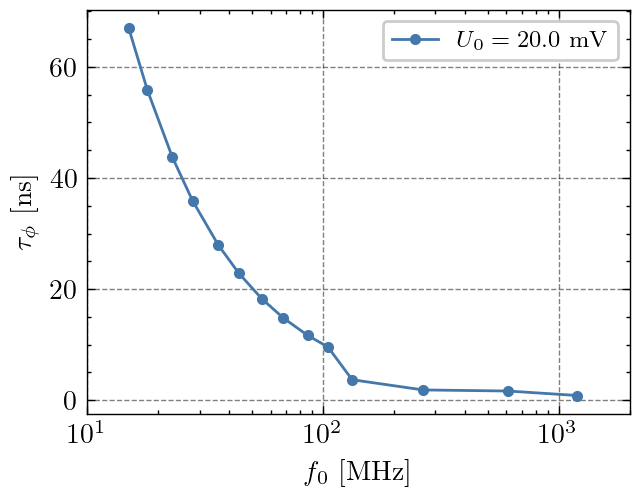

In [39]:
amp  = 0.02
norm = Normalize(vmin=AMPLITUDE_LIST[0], vmax=AMPLITUDE_LIST[-1])
cmap = plt.get_cmap('cividis')
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
ax.plot(FREQ_LIST_MHZ, taus[amp].values, '.-', label=f'$U_0 = {1000*amp}$ mV')
# for amp in AMPLITUDE_LIST[0:1]:
#     ax.plot(FREQ_LIST_MHZ, taus[amp].values, '.-', color=cmap(norm(amp)), label=f'$U_0 = {1000*amp}$ mV')
ax.set_xlim(1e1,2e3)
ax.set_xscale('log')
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$\\tau_{\phi}$ [ns]")
ax.legend(fontsize='small')

fig.savefig(f"plots/svg/tau_vs_freq.svg", transparent=True)
fig.savefig(f"plots/pdf/tau_vs_freq.pdf", transparent=False)
fig.savefig(f"plots/png/tau_vs_freq.png", transparent=False)

In [34]:
frs = []
for amp in AMPLITUDE_LIST:
    idx = np.where(np.isinf(taus[amp].values),-np.inf,taus[amp].values).argmax()
    fr  = FREQ_LIST_MHZ[idx]
    frs.append(fr)

### Parameter Space

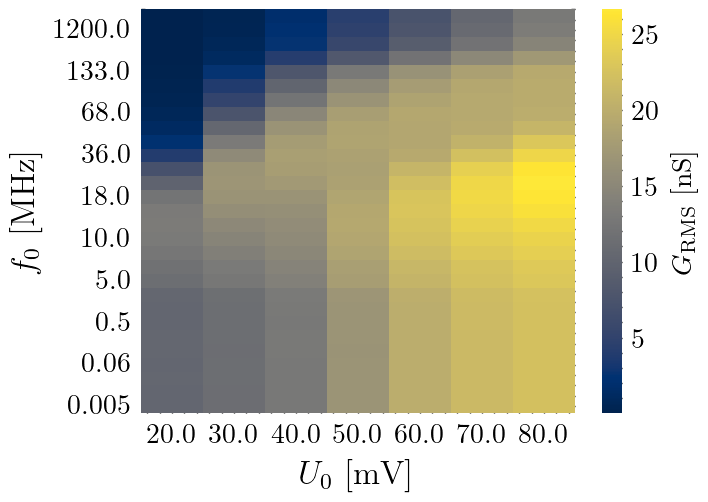

In [17]:
rms_arr = pd.DataFrame([[(np.sqrt(np.sum(data[amp][freq]['Observable'].values[N_SKIP*SAMPLE_P_PERIOD:].copy()**2))*1e-9)/amp
                         for amp in AMPLITUDE_LIST] for freq in FREQ_LIST_MHZ], columns=np.array(AMPLITUDE_LIST)*1000, index=FREQ_LIST_MHZ)
fig, ax = plt.subplots(dpi=200)
ax      = sns.heatmap(rms_arr, cmap='cividis', ax=ax, cbar_kws={'label':"$G_{\\text{RMS}}$ [nS]"}, annot=False)
# im      = ax.imshow(thd_arr, cmap='cividis', aspect='auto', interpolation='bilinear')
_       = plt.yticks(rotation=0)
_       = ax.set_ylabel("$f_0$ [MHz]", fontsize='large')
_       = ax.set_xlabel("$U_0$ [mV]", fontsize='large')
_       = ax.invert_yaxis()

fig.savefig(f"plots/svg/RMS_map.svg", transparent=True)
fig.savefig(f"plots/pdf/RMS_map.pdf", transparent=False)
fig.savefig(f"plots/png/RMS_map.png", transparent=False)

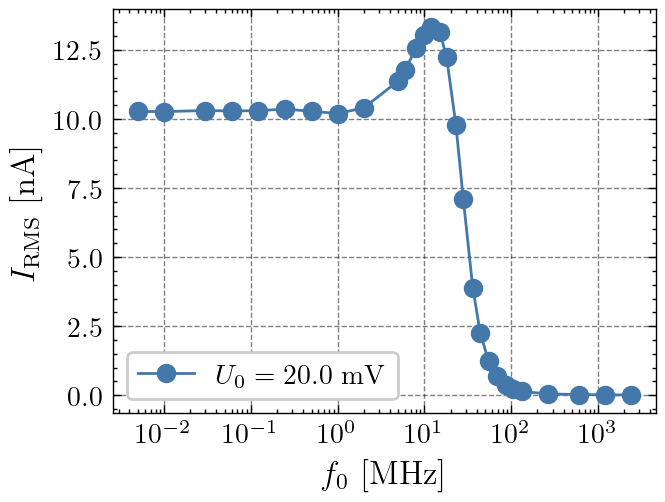

In [ ]:
amp     = 20.0
fig, ax = plt.subplots(dpi=200)
ax.plot(rms_arr[amp], 'o-', label=f"$U_0 = {amp}$ mV")
ax.set_xscale('log')
_ = plt.yticks(rotation=0)
_ = ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
_ = ax.set_ylabel("$I_{\\text{RMS}}$ [nA]", fontsize='large')
_ = ax.legend(loc='lower left')

fig.savefig(f"plots/svg/RMS_at_{amp}.svg", transparent=True)
fig.savefig(f"plots/pdf/RMS_at_{amp}.pdf", transparent=False)
fig.savefig(f"plots/png/RMS_at_{amp}.png", transparent=False)

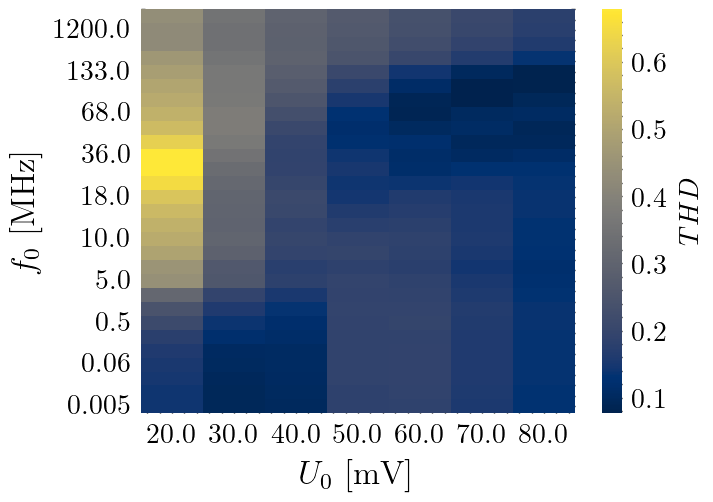

In [8]:
thd_arr = pd.DataFrame([[total_harmonic_distortion(signal=data[amp][freq]['Observable'].values[N_SKIP*SAMPLE_P_PERIOD:], f0=freq*1e6, dt=dts[freq], N_f=18, snr_threshold=100) 
                         for amp in AMPLITUDE_LIST] for freq in FREQ_LIST_MHZ], columns=np.array(AMPLITUDE_LIST)*1000, index=FREQ_LIST_MHZ)
fig, ax = plt.subplots(dpi=200)
ax      = sns.heatmap(thd_arr, cmap='cividis', ax=ax, cbar_kws={'label':'$THD$'}, annot=False)
_       = plt.yticks(rotation=0)
_       = ax.set_ylabel("$f_0$ [MHz]", fontsize='large')
_       = ax.set_xlabel("$U_0$ [mV]", fontsize='large')
_       = ax.invert_yaxis()

fig.savefig(f"plots/svg/thd_map.svg", transparent=True)
fig.savefig(f"plots/pdf/thd_map.pdf", transparent=False)
fig.savefig(f"plots/png/thd_map.png", transparent=False)

In [9]:
susceptance = []
conductance = []
for amp in AMPLITUDE_LIST:
    areas1 = []
    areas2 = []
    for freq in FREQ_LIST_MHZ:
        t = time[freq][:-1][:SAMPLE_P_PERIOD+1]*1e6
        x = data[amp][freq]['E0'].values[N_SKIP*SAMPLE_P_PERIOD:(N_SKIP+1)*SAMPLE_P_PERIOD+1]*1000
        y = data[amp][freq]['Observable'].values[N_SKIP*SAMPLE_P_PERIOD:(N_SKIP+1)*SAMPLE_P_PERIOD+1]*1e-6
        b = np.trapz(y, x)
        g = 2 * np.trapz(y*x, t) / (t[-1]-t[0])
        areas1.append((b/(amp**2))*1e-6)
        areas2.append((g/(amp**2))*1e-6)
    susceptance.append(areas1)
    conductance.append(areas2)

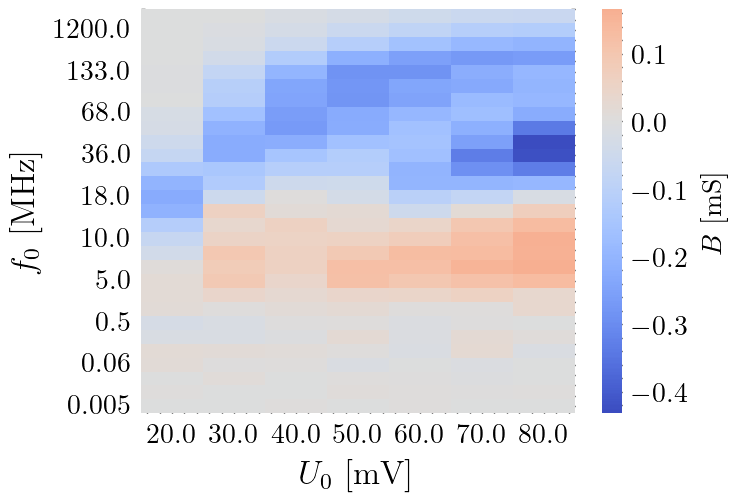

In [10]:
fig, ax = plt.subplots(dpi=200)
ax  = sns.heatmap(pd.DataFrame(susceptance, columns=FREQ_LIST_MHZ, index=np.array(AMPLITUDE_LIST)*1000).T, cmap='coolwarm',
                  ax=ax, center=0, cbar_kws={'label':"$B$ [mS]"})
_   = plt.yticks(rotation=0)
_   = ax.set_ylabel("$f_0$ [MHz]", fontsize='large')
_   = ax.set_xlabel("$U_0$ [mV]", fontsize='large')
_   = ax.invert_yaxis()

fig.savefig(f"plots/svg/B_map.svg", transparent=True)
fig.savefig(f"plots/pdf/B_map.pdf", transparent=False)
fig.savefig(f"plots/png/B_map.png", transparent=False)

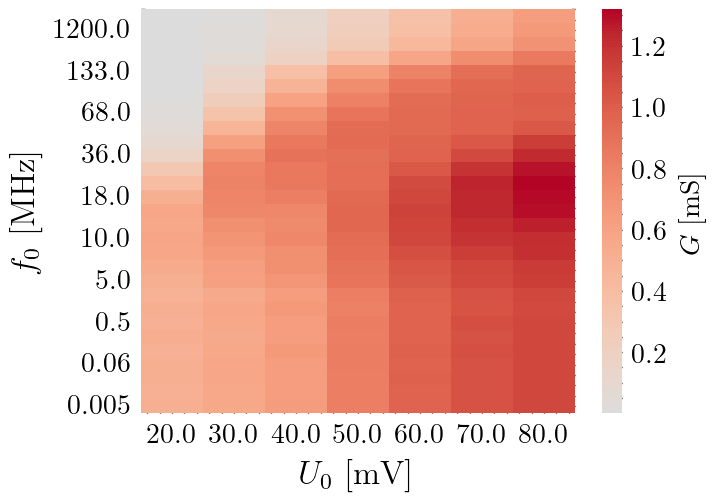

In [11]:
fig, ax = plt.subplots(dpi=200)
ax  = sns.heatmap(pd.DataFrame(conductance, columns=FREQ_LIST_MHZ, index=np.array(AMPLITUDE_LIST)*1000).T, cmap='coolwarm',
                  ax=ax, center=0, cbar_kws={'label':"$G$ [mS]"})
_   = plt.yticks(rotation=0)
_   = ax.set_ylabel("$f_0$ [MHz]", fontsize='large')
_   = ax.set_xlabel("$U_0$ [mV]", fontsize='large')
_   = ax.invert_yaxis()

fig.savefig(f"plots/svg/G_map.svg", transparent=True)
fig.savefig(f"plots/pdf/G_map.pdf", transparent=False)
fig.savefig(f"plots/png/G_map.png", transparent=False)

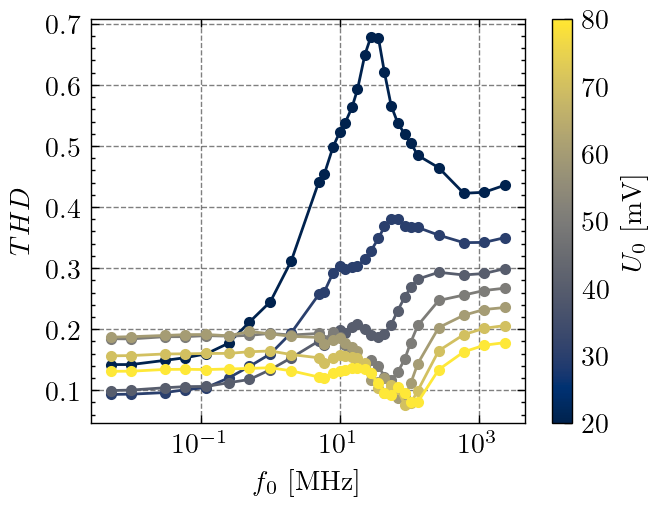

In [13]:
cm      = plt.get_cmap('cividis')
norm    = Normalize(vmin=1000*min(AMPLITUDE_LIST), vmax=1000*max(AMPLITUDE_LIST))
fig, ax = plt.subplots(dpi=200)
for amp in AMPLITUDE_LIST:
    ax.plot(thd_arr[amp*1000], '.-', color=cm(norm(1000*amp)))
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$THD$")
ax.set_xscale("log")
sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$U_0$ [mV]")

fig.savefig(f"plots/svg/thd_vs_freq.svg", transparent=True)
fig.savefig(f"plots/pdf/thd_vs_freq.pdf", transparent=False)
fig.savefig(f"plots/png/thd_vs_freq.png", transparent=False)

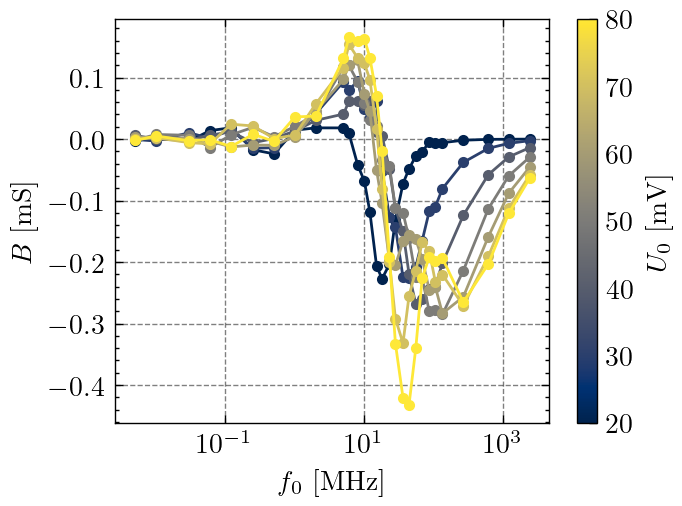

In [14]:
cm      = plt.get_cmap('cividis')
norm    = Normalize(vmin=1000*min(AMPLITUDE_LIST), vmax=1000*max(AMPLITUDE_LIST))
fig, ax = plt.subplots(dpi=200)
for i, amp in enumerate(AMPLITUDE_LIST):
    ax.plot(FREQ_LIST_MHZ, susceptance[i], '.-', color=cm(norm(1000*amp)))
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$B$ [mS]")
ax.set_xscale("log")
sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$U_0$ [mV]")

fig.savefig(f"plots/svg/B_vs_freq.svg", transparent=True)
fig.savefig(f"plots/pdf/B_vs_freq.pdf", transparent=False)
fig.savefig(f"plots/png/B_vs_freq.png", transparent=False)

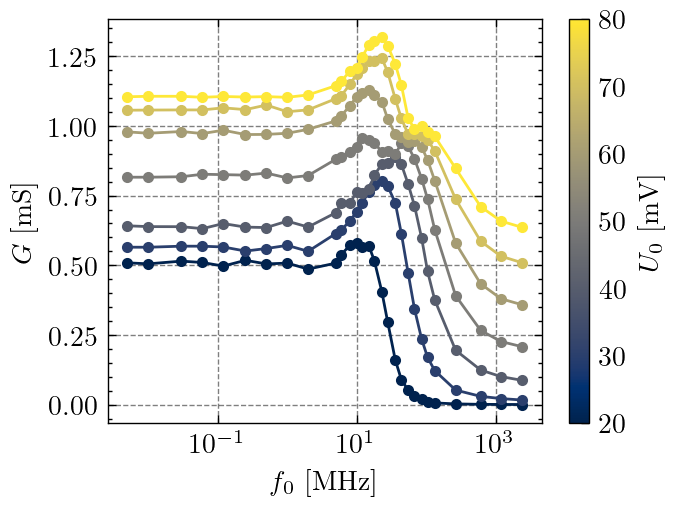

In [15]:
cm      = plt.get_cmap('cividis')
norm    = Normalize(vmin=1000*min(AMPLITUDE_LIST), vmax=1000*max(AMPLITUDE_LIST))
fig, ax = plt.subplots(dpi=200)
for i, amp in enumerate(AMPLITUDE_LIST):
    ax.plot(FREQ_LIST_MHZ, conductance[i], '.-', color=cm(norm(1000*amp)))
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$G$ [mS]")
ax.set_xscale("log")
sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$U_0$ [mV]")

fig.savefig(f"plots/svg/G_vs_freq.svg", transparent=True)
fig.savefig(f"plots/pdf/G_vs_freq.pdf", transparent=False)
fig.savefig(f"plots/png/G_vs_freq.png", transparent=False)

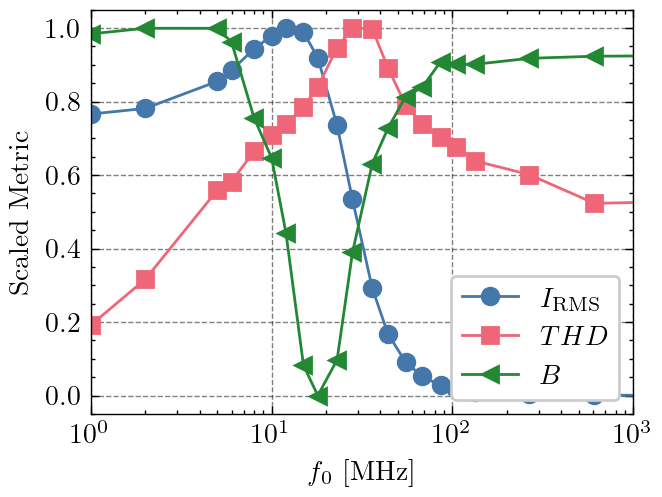

In [18]:
amp     = 20.0
fig, ax = plt.subplots(dpi=200)
ax.plot(min_max_scale(rms_arr[amp]), '-o', label='$I_{\\text{RMS}}$')
ax.plot(min_max_scale(thd_arr[amp]), '-s', label='$THD$')
ax.plot(FREQ_LIST_MHZ, min_max_scale(susceptance[0]), '-<', label='$B$')
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("Scaled Metric")
ax.set_xscale("log")
ax.legend(loc='lower right')
ax.set_xlim(1e0,1e3)
fig.savefig(f"plots/svg/metrics_vs_freq_{amp:.3f}.svg", transparent=True)
fig.savefig(f"plots/pdf/metrics_vs_freq_{amp:.3f}.pdf", transparent=False)
fig.savefig(f"plots/png/metrics_vs_freq_{amp:.3f}.png", transparent=False)